In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import pygrib
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
def wind_power_output(pwr_crv_str, speed_arr):
    """Uses power curve data from NRES and array of speeds to create correlated array of power outputs in MW of 
    that wind turbine in relation to each of those speeds. Power curve array has 3 columns: speed, power output, 
    capacity factor"""

    power_curve = np.loadtxt(pwr_crv_str,delimiter=",", dtype=str)
    power_curve = power_curve[1:,:].astype('float')
    speed_limited = np.where((speed_arr>25) | (speed_arr<0),0,speed_arr) #curtails power output above max
    power_outputs = np.interp(speed_limited,power_curve[:,0],power_curve[:,1])
    
    return power_outputs

In [3]:
speed_dist = np.linspace(0,25,num=1000)
pwr_crv_str = "2023_NREL_8.3MW_196.csv"
power_outputs = wind_power_output(pwr_crv_str,speed_dist)

In [4]:
power_curve = np.loadtxt('2023_NREL_8.3MW_196.csv',delimiter=",", dtype=str)[1:,:].astype('float')
power_curve2 = np.loadtxt('2016CACost_NREL_Reference_8MW_180.csv',delimiter=",", dtype=str)[1:,:].astype('float') #Harveys Work 


v_min = 3
v_split = 8.67
v_rated = 13
i = 16

v_min2 = 4
v_split2 = 9
v_rated2 = 12
ii = 14

fit_low = np.polyfit(power_curve[2:i,0],power_curve[2:i,1]/1000,deg=3,rcond=1e-14)
fit_high = np.polyfit(power_curve[i:22,0],power_curve[i:22,1]/1000,deg=3,rcond=1e-14)

fit_low2 = np.polyfit(power_curve2[2:ii,0],power_curve2[2:ii,1]/1000,deg=3,rcond=1e-14) #Harveys Work 
fit_high2 = np.polyfit(power_curve2[ii:19,0],power_curve2[ii:19,1]/1000,deg=3,rcond=1e-14)

fit_low_text = np.round(fit_low,decimals=3)
fit_high_text = np.round(fit_high,decimals=3)

fit_low_text2 = np.round(fit_low2,decimals=3) #Harveys Work 
fit_high_text2 = np.round(fit_high2,decimals=3)

In [5]:
speed_dist_1 = np.linspace(0,25,num=50)
pwr_crv_str = "2023_NREL_8.3MW_196.csv"
#Harveys Work
pwr_crv_str2 = "2016CACost_NREL_Reference_8MW_180.csv"

power_outputs_1 = (wind_power_output(pwr_crv_str,speed_dist_1))/1000
#Harveys Work
power_outputs_2 = (wind_power_output(pwr_crv_str2,speed_dist_1))/1000


x_low = np.linspace(v_min,v_split,num=500)
x_high = np.linspace(v_split,v_rated,num=500)
v_low = np.polyval(fit_low,x_low)
v_high = np.polyval(fit_high,x_high)
x_stack = np.hstack((x_low,x_high))
v_stack = np.hstack((v_low,v_high))

#Harveys Work
x_low2 = np.linspace(v_min2,v_split2,num=500)
x_high2 = np.linspace(v_split2,v_rated2,num=500)
v_low2 = np.polyval(fit_low2,x_low2)
v_high2 = np.polyval(fit_high2,x_high2)
x_stack2 = np.hstack((x_low2,x_high2))
v_stack2= np.hstack((v_low2,v_high2))

#plt.figure(dpi =300)
#plt.plot(speed_dist_1,power_outputs_1,".", label='2023 NREL 8.3MW 196m')
#plt.plot(speed_dist_1,power_outputs_2,color = "green", label='2016 NREL 8MW 180m')

#plt.plot(x_stack, v_stack,color='tab:orange', linestyle = '-', label='Model')
#plt.axhline(y=8.3,color='tab:orange', linestyle = '-', xmin=13*0.1/2.5,xmax = 23.9 *0.1/2.5)
#plt.axhline(y=0,color='tab:orange', linestyle = '-', xmin=0.008,xmax = 0.151)
#plt.axhline(y=0,color='tab:orange', linestyle = '-', xmin=0.008,xmax = 11.4)
#plt.xlabel(r'Wind speed (ms$^{-1}$)')
#plt.ylabel('Power (MW)')

#plt.text(12,3,f'$α_1 = {fit_low_text[0]}, β_1  = {fit_low_text[1]}$, \n$ γ_1 = {fit_low_text[2]}, 𝛿_1 = {fit_low_text[3]}$',size=12)
#plt.text(12,2,f'$α_2 = {fit_high_text[0]}, β_2  = {fit_high_text[1]}$, \n$ γ_2 = {fit_high_text[2]}, 𝛿_2 = {fit_high_text[3]}$',size=12)
#plt.title('Power Curve')
#plt.legend()
#plt.grid(alpha=0.4)
#plt.savefig('./figures/power_curve.pdf',bbox_inches='tight')

In [6]:
def wind_eval(orig_height, target_height, ds, surface_roughness):
    """Takes in an xarray dataset and evaluates the wind speed magnitude at a certain height using formula, 
    then creates a new variables and assigns it to the database and replaces the original wind speed magnitude.
    Note: Sets values of wind magnitude > 25m/s to zero."""
    #creating magnitude
    ds = ds.assign(wind_mag=lambda ds: np.sqrt(ds.u100**2 + ds.v100**2))
    
    #function to adjust for height of wind turbine
    def multiply(x,surface_roughness=surface_roughness,orig_height=orig_height,target_height=target_height):
        alpha = 0.5*(surface_roughness/10)**0.2
        factor = (target_height/orig_height)**alpha
        return x*factor
        
    ds['wind_mag'] = xr.apply_ufunc(multiply, ds['wind_mag'],input_core_dims=[["longitude","latitude"]],
               output_core_dims=[["longitude", "latitude"]], dask = 'allowed', vectorize = True)
    #dropping values above 25ms-1 (cut-out speed)
    ds['wind_mag'] = ds['wind_mag'].where((ds['wind_mag']<=25) & (ds['wind_mag']>0),0, drop=False)
    ds.wind_mag.attrs["units"] = "m s**-1"
    return ds

In [7]:
original_height = 100 #metres
height = 120 #metres
height2 = 112 #Harveys work 
surface_roughness = 0.0005

In [8]:
paths = ["/share/data1/xzcaplbl/data/2018_to_2022.grib"]
ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': 200} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds = wind_eval(original_height,height,ds,surface_roughness) #My data set
ds2 = wind_eval(original_height,height2,ds,surface_roughness) #Harveys Data set 

/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


Text(0, 0.5, 'Wind Speed (m/s)')

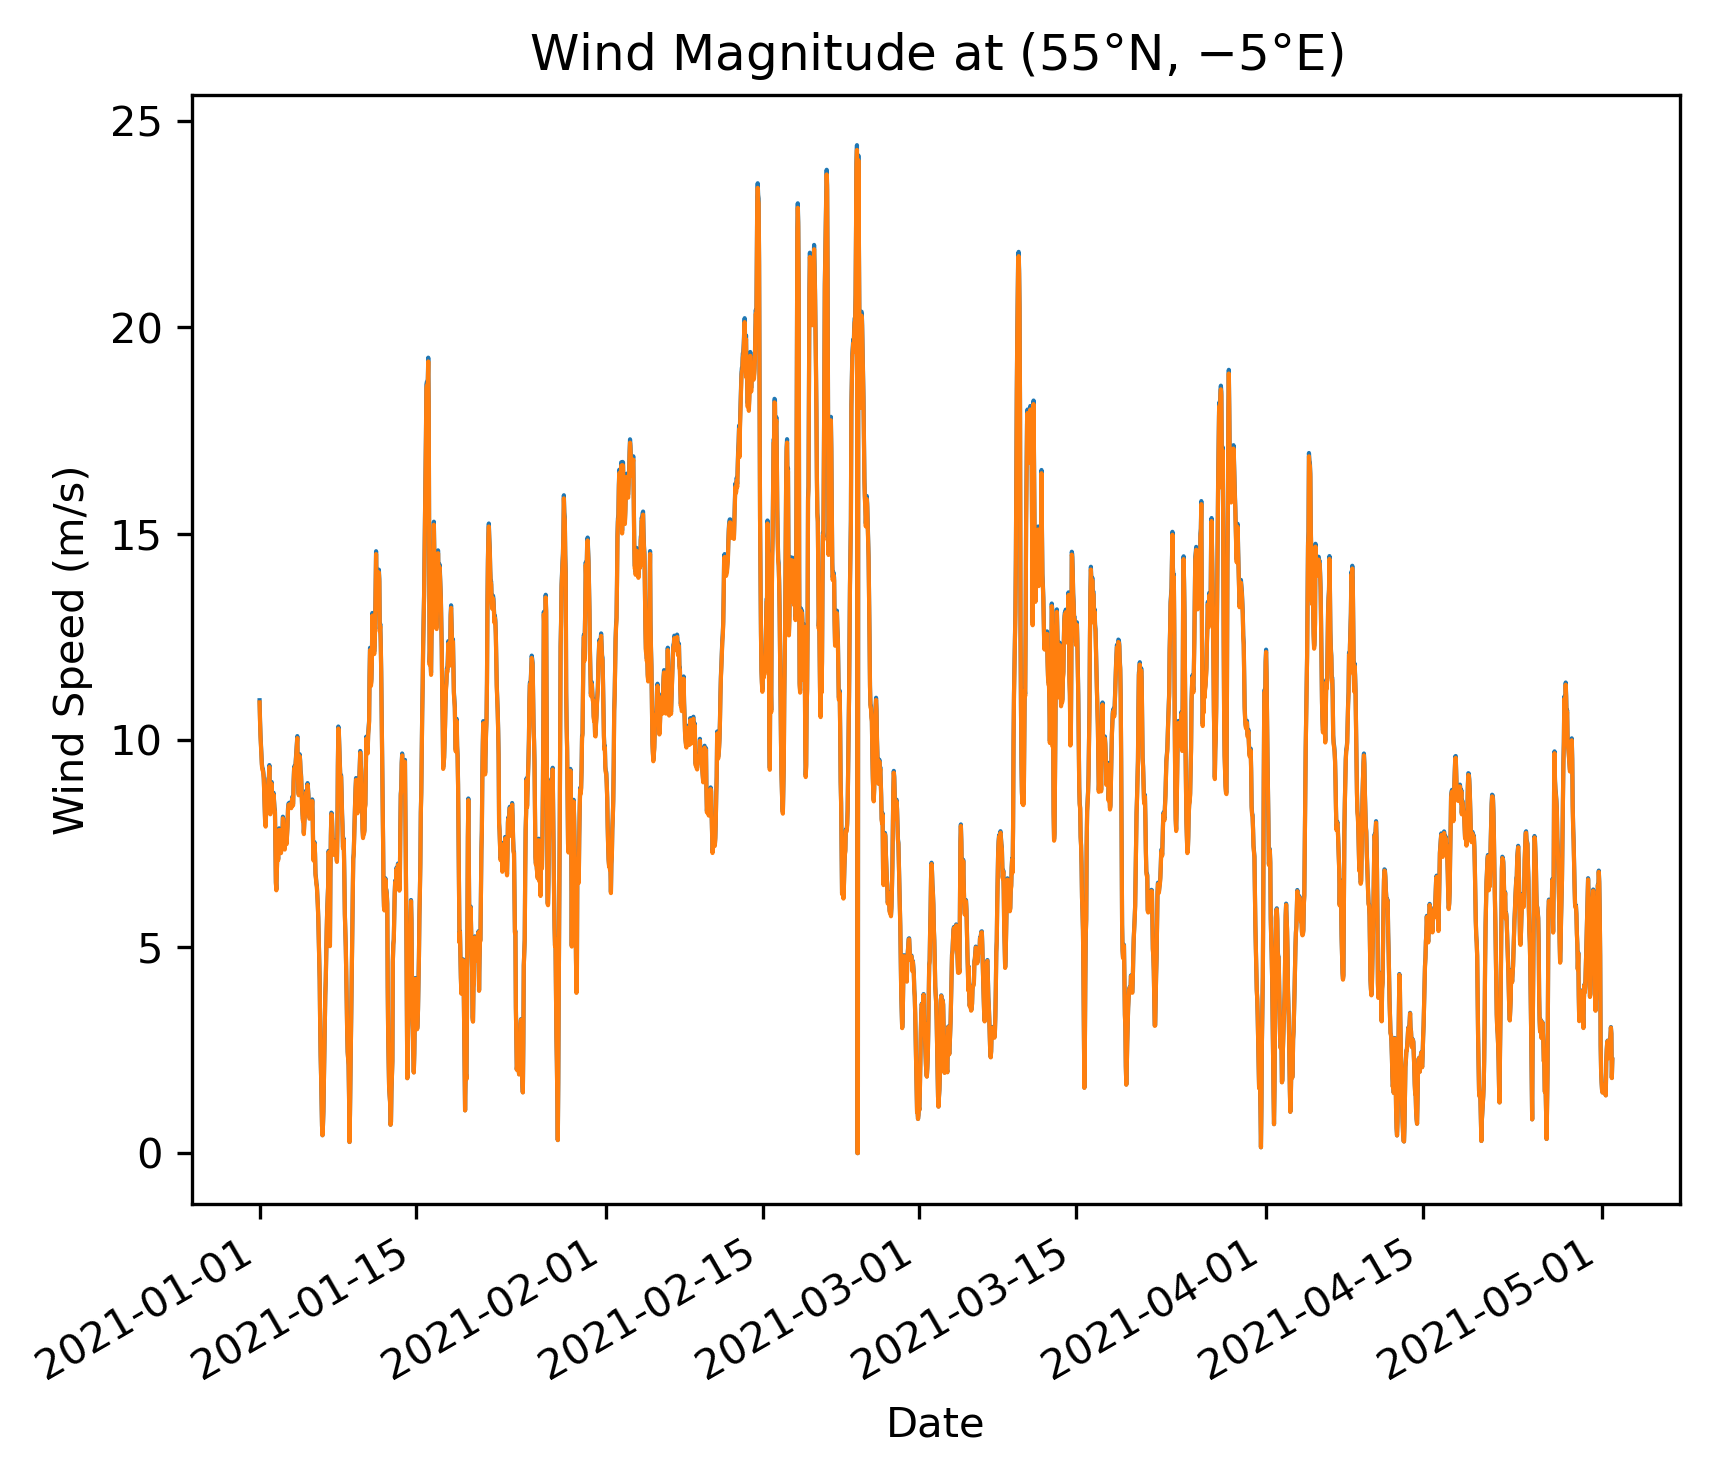

In [12]:
longitude = -5
latitude = 55

#plotting
plt.figure(dpi=300)
ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2021-01-01', '2021-05-01'))['wind_mag'].plot(linewidth=1)
ds2.sel(latitude=[latitude], longitude=[longitude],time=slice('2021-01-01', '2021-05-01'))['wind_mag'].plot(linewidth=1)

plt.title(f'Wind Magnitude at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")

Text(0, 0.5, 'Wind Speed (m/s)')

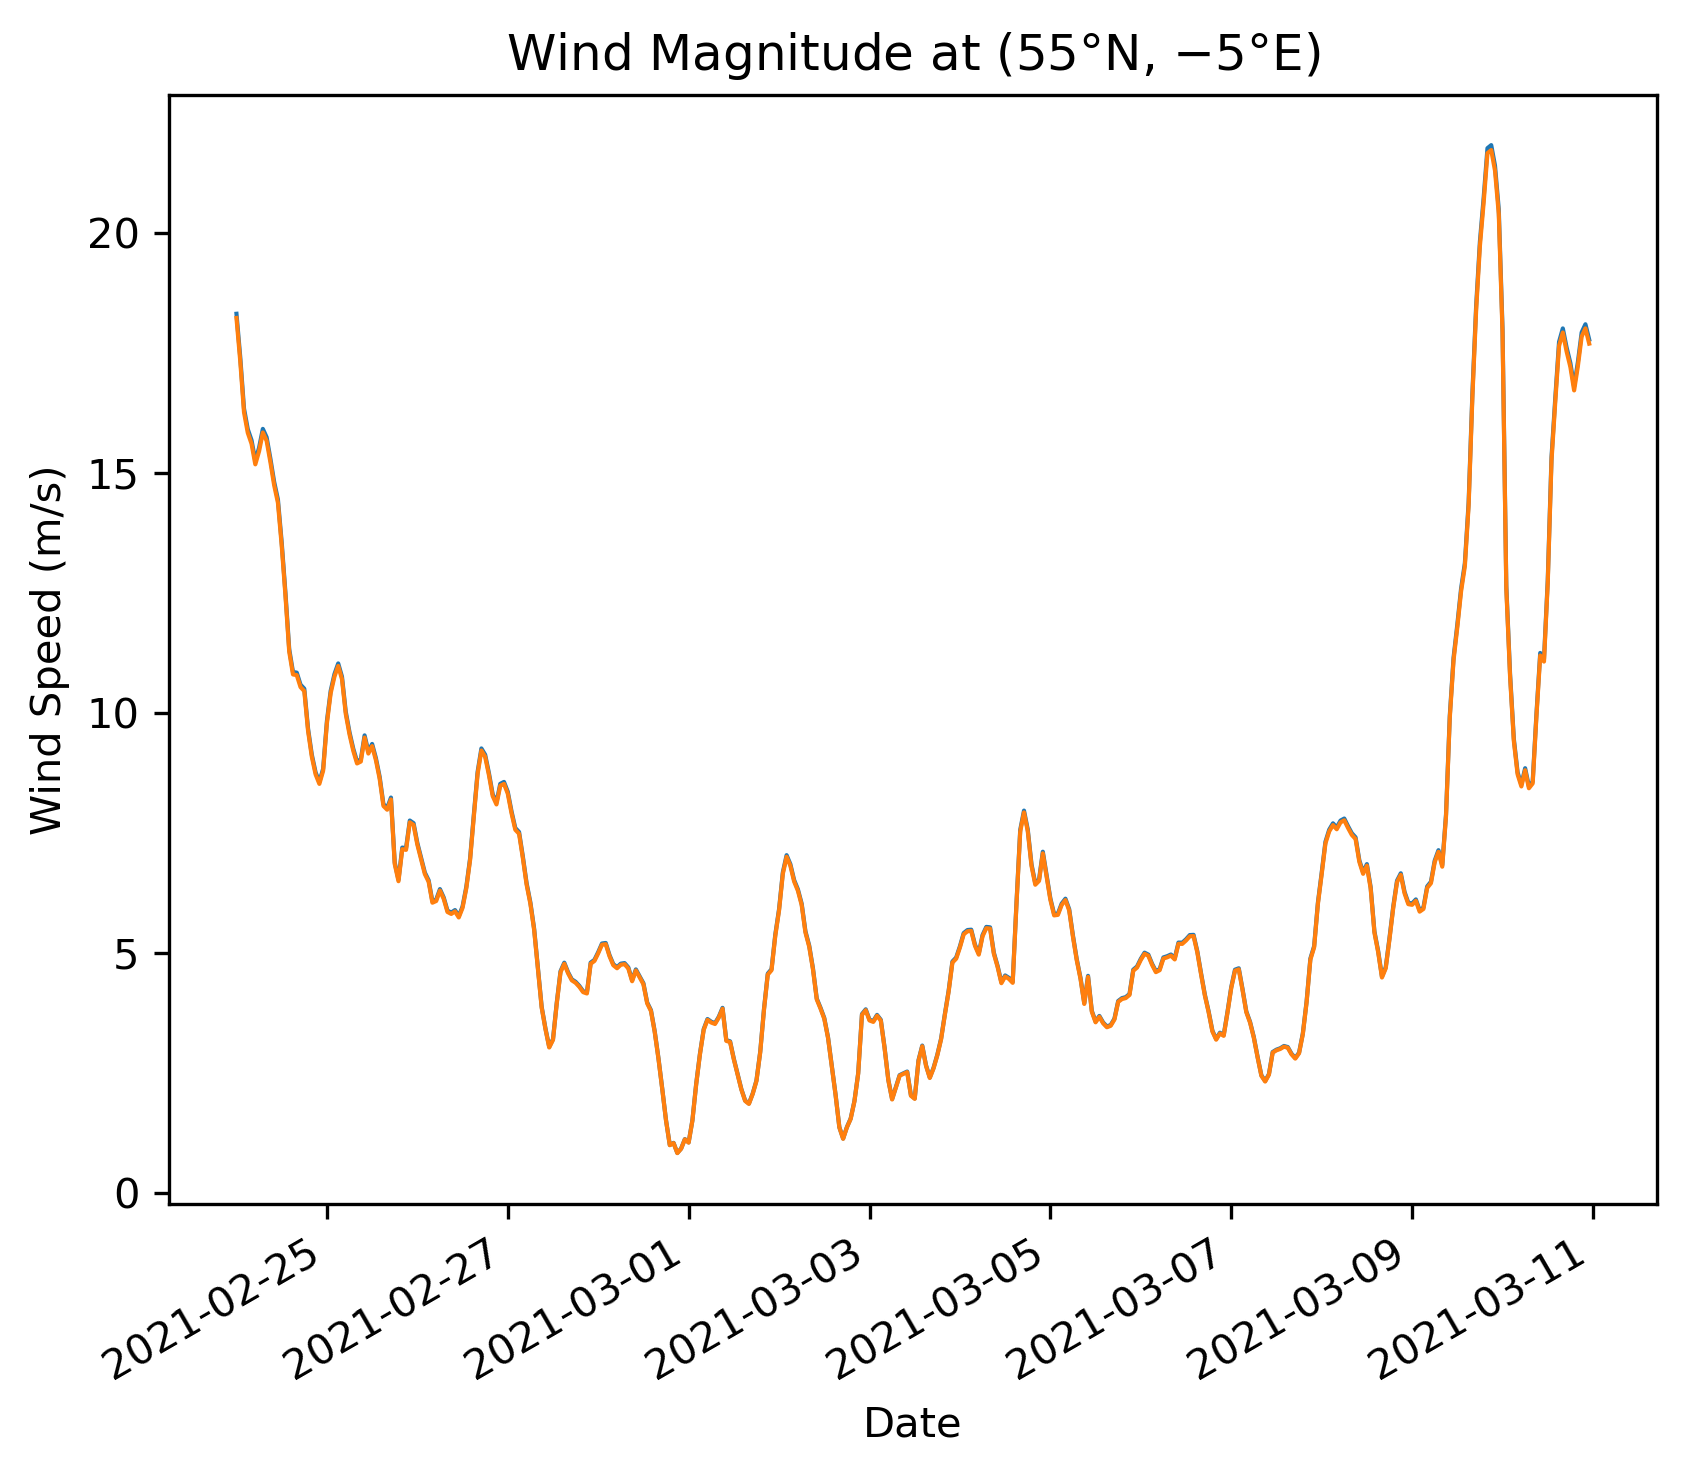

In [13]:
longitude = -5
latitude = 55

#plotting
plt.figure(dpi=300)
ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2021-02-24', '2021-03-10'))['wind_mag'].plot(linewidth=1)
ds2.sel(latitude=[latitude], longitude=[longitude],time=slice('2021-02-24', '2021-03-10'))['wind_mag'].plot(linewidth=1)


plt.title(f'Wind Magnitude at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")

The above two cells are designed to check the quality of the my dataset, along with trying to identify specific blackout points in the wind data. Above is investigating the event at the start of March which was the longest Dunkelflaute that Britain had experienced in the last decade.  Between the 26th of February and the 8th of March. 

credit: https://reports.electricinsights.co.uk/q1-2021/when-the-wind-goes-gas-fills-in-the-gap/#:~:text=The%20event%20at%20the%20start,did%20not%20go%20above%2020%25

Text(0.5, 1.0, 'Wind Magnitude at Latitude 55 and Longitude 6')

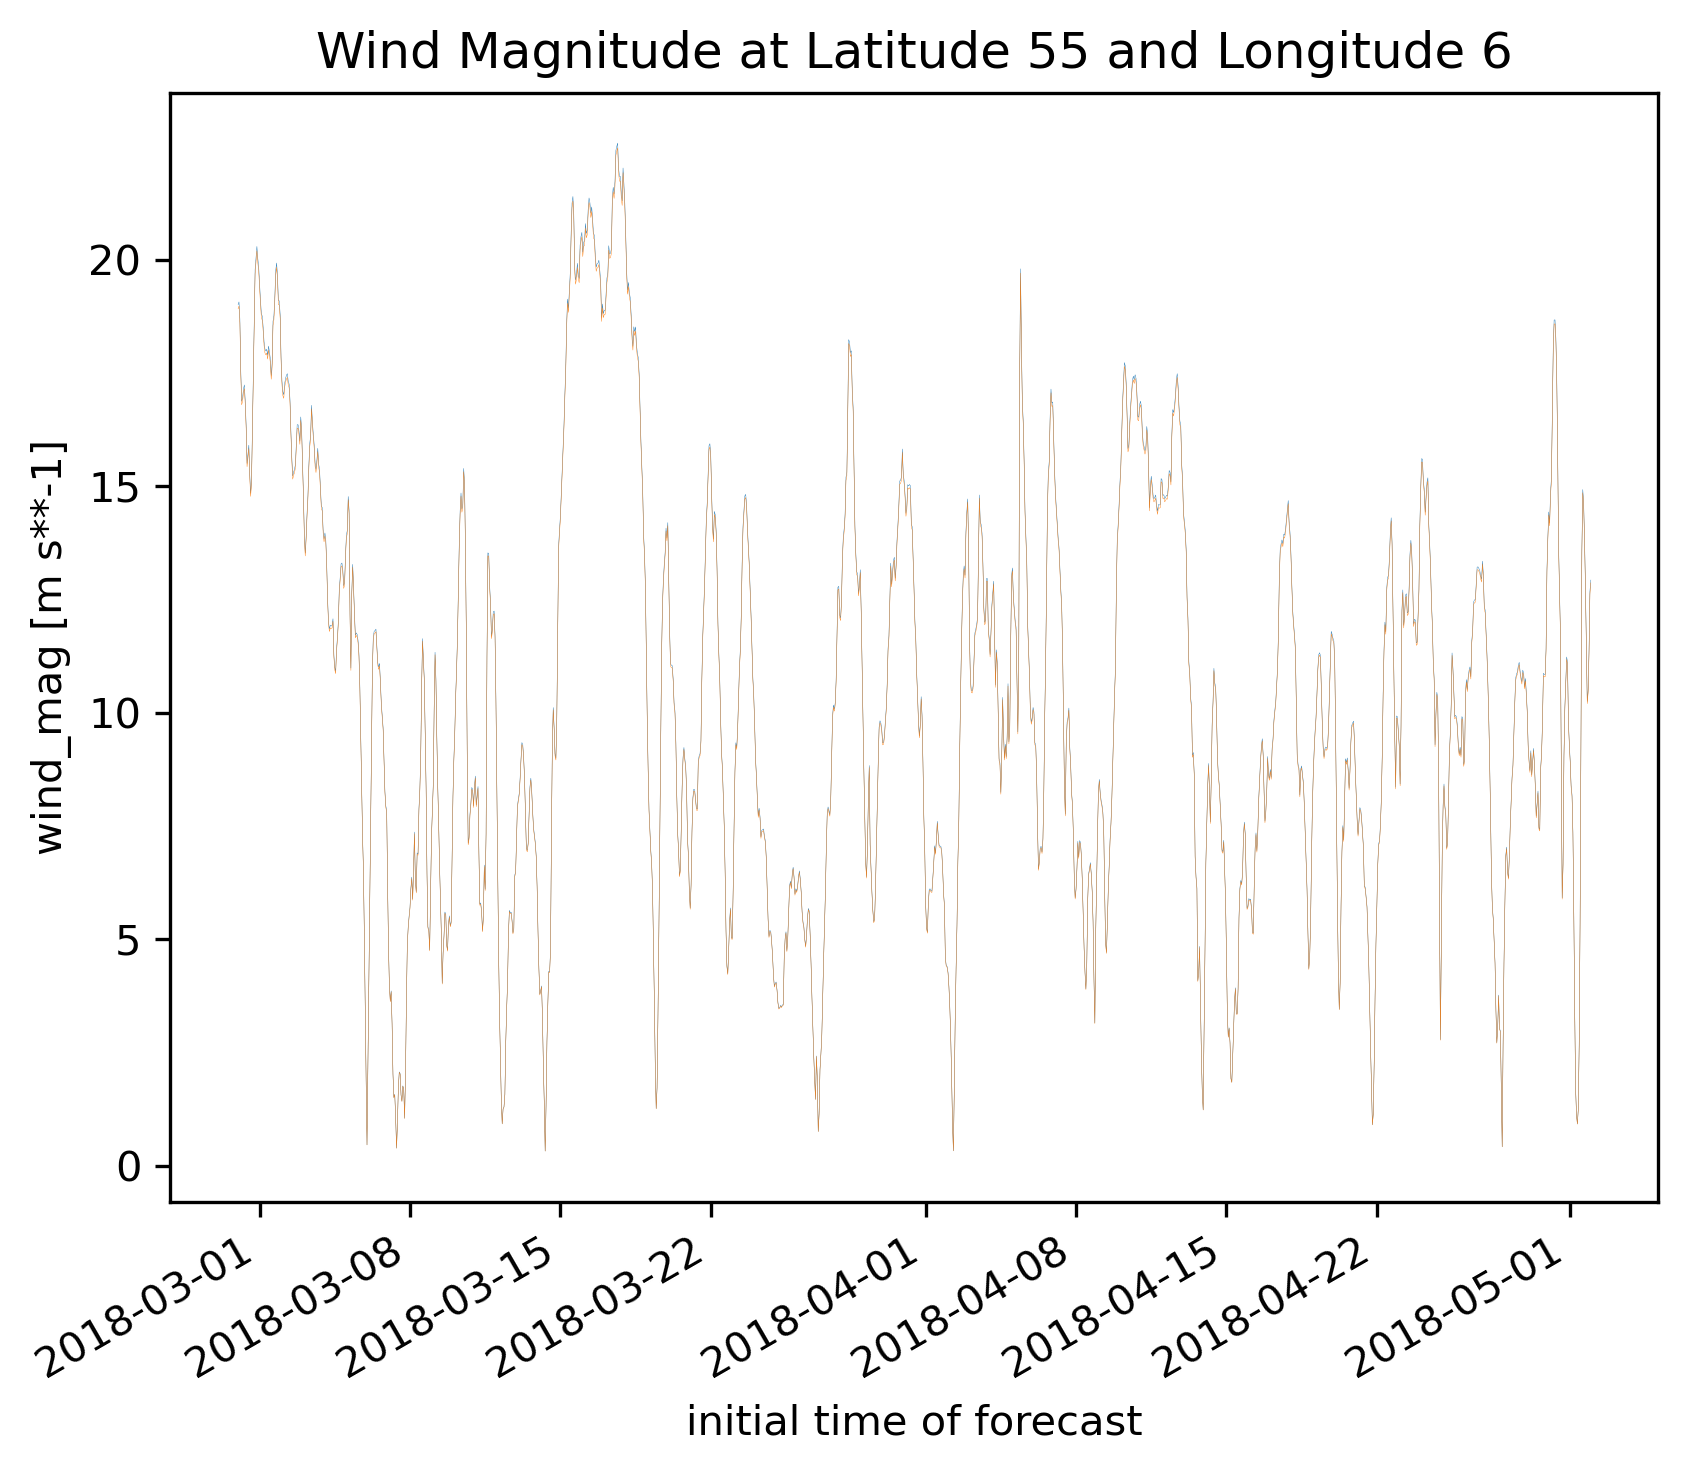

In [11]:
longitude = 6
lattiude = 52

#plotting
plt.figure(dpi=300)
ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2018-02-28', '2018-05-01'))['wind_mag'].plot(linewidth=0.1)
ds2.sel(latitude=[latitude], longitude=[longitude],time=slice('2018-02-28', '2018-05-01'))['wind_mag'].plot(linewidth=0.1)

plt.title('Wind Magnitude at Latitude {} and Longitude {}'.format(latitude, longitude))

Text(0.5, 1.0, 'Wind Magnitude at Latitude 52 and Longitude 5')

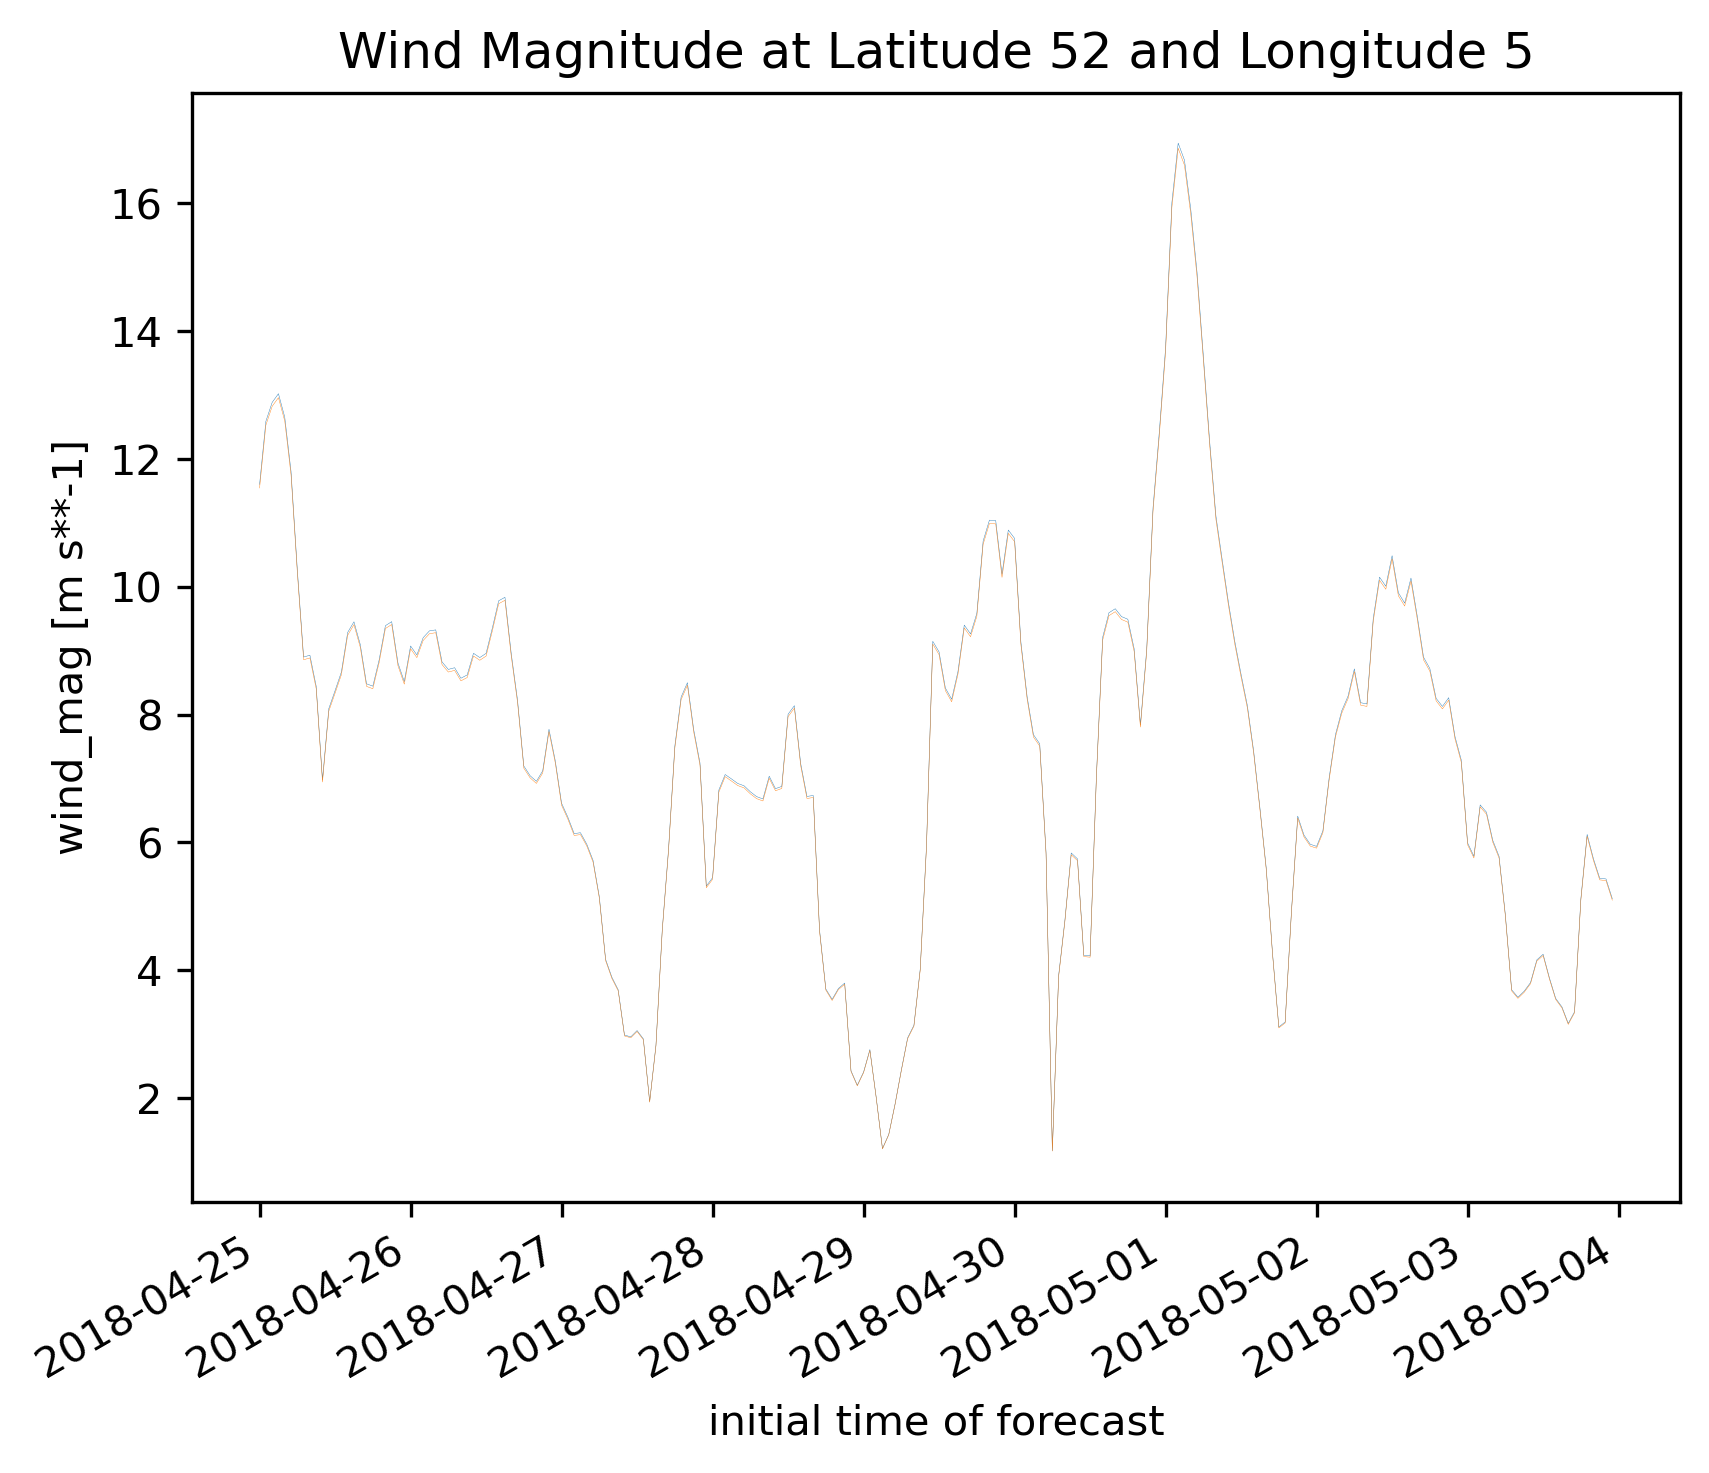

In [12]:
longitude = 5
latitude = 52

#plotting
plt.figure(dpi=300)
ds.sel(latitude=[latitude], longitude=[longitude],time=slice('2018-04-25', '2018-05-03'))['wind_mag'].plot(linewidth=0.1)
ds2.sel(latitude=[latitude], longitude=[longitude],time=slice('2018-04-25', '2018-05-03'))['wind_mag'].plot(linewidth=0.1)

plt.title('Wind Magnitude at Latitude {} and Longitude {}'.format(latitude, longitude))

The 2 figures directly above show the potential Dunkelflaute event that occured in the netherlands on the 30th of april 2018. however, from inspection of the data we see a similar dip in the data for the 29th of april 2018 aswell. 

credit: https://iopscience.iop.org/article/10.1088/1742-6596/1618/6/062042/pdf

In [13]:
paths2 = ["/share/data1/xzcaplbl/data/2012_to_2017.grib"]
ds3 = xr.open_mfdataset(paths2, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': 200} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds3 = wind_eval(original_height,height,ds3,surface_roughness) #My data set
ds4 = wind_eval(original_height,height2,ds3,surface_roughness) #Harveys Data set 

Text(0.5, 1.0, 'Wind Magnitude at Latitude 58 and Longitude 5')

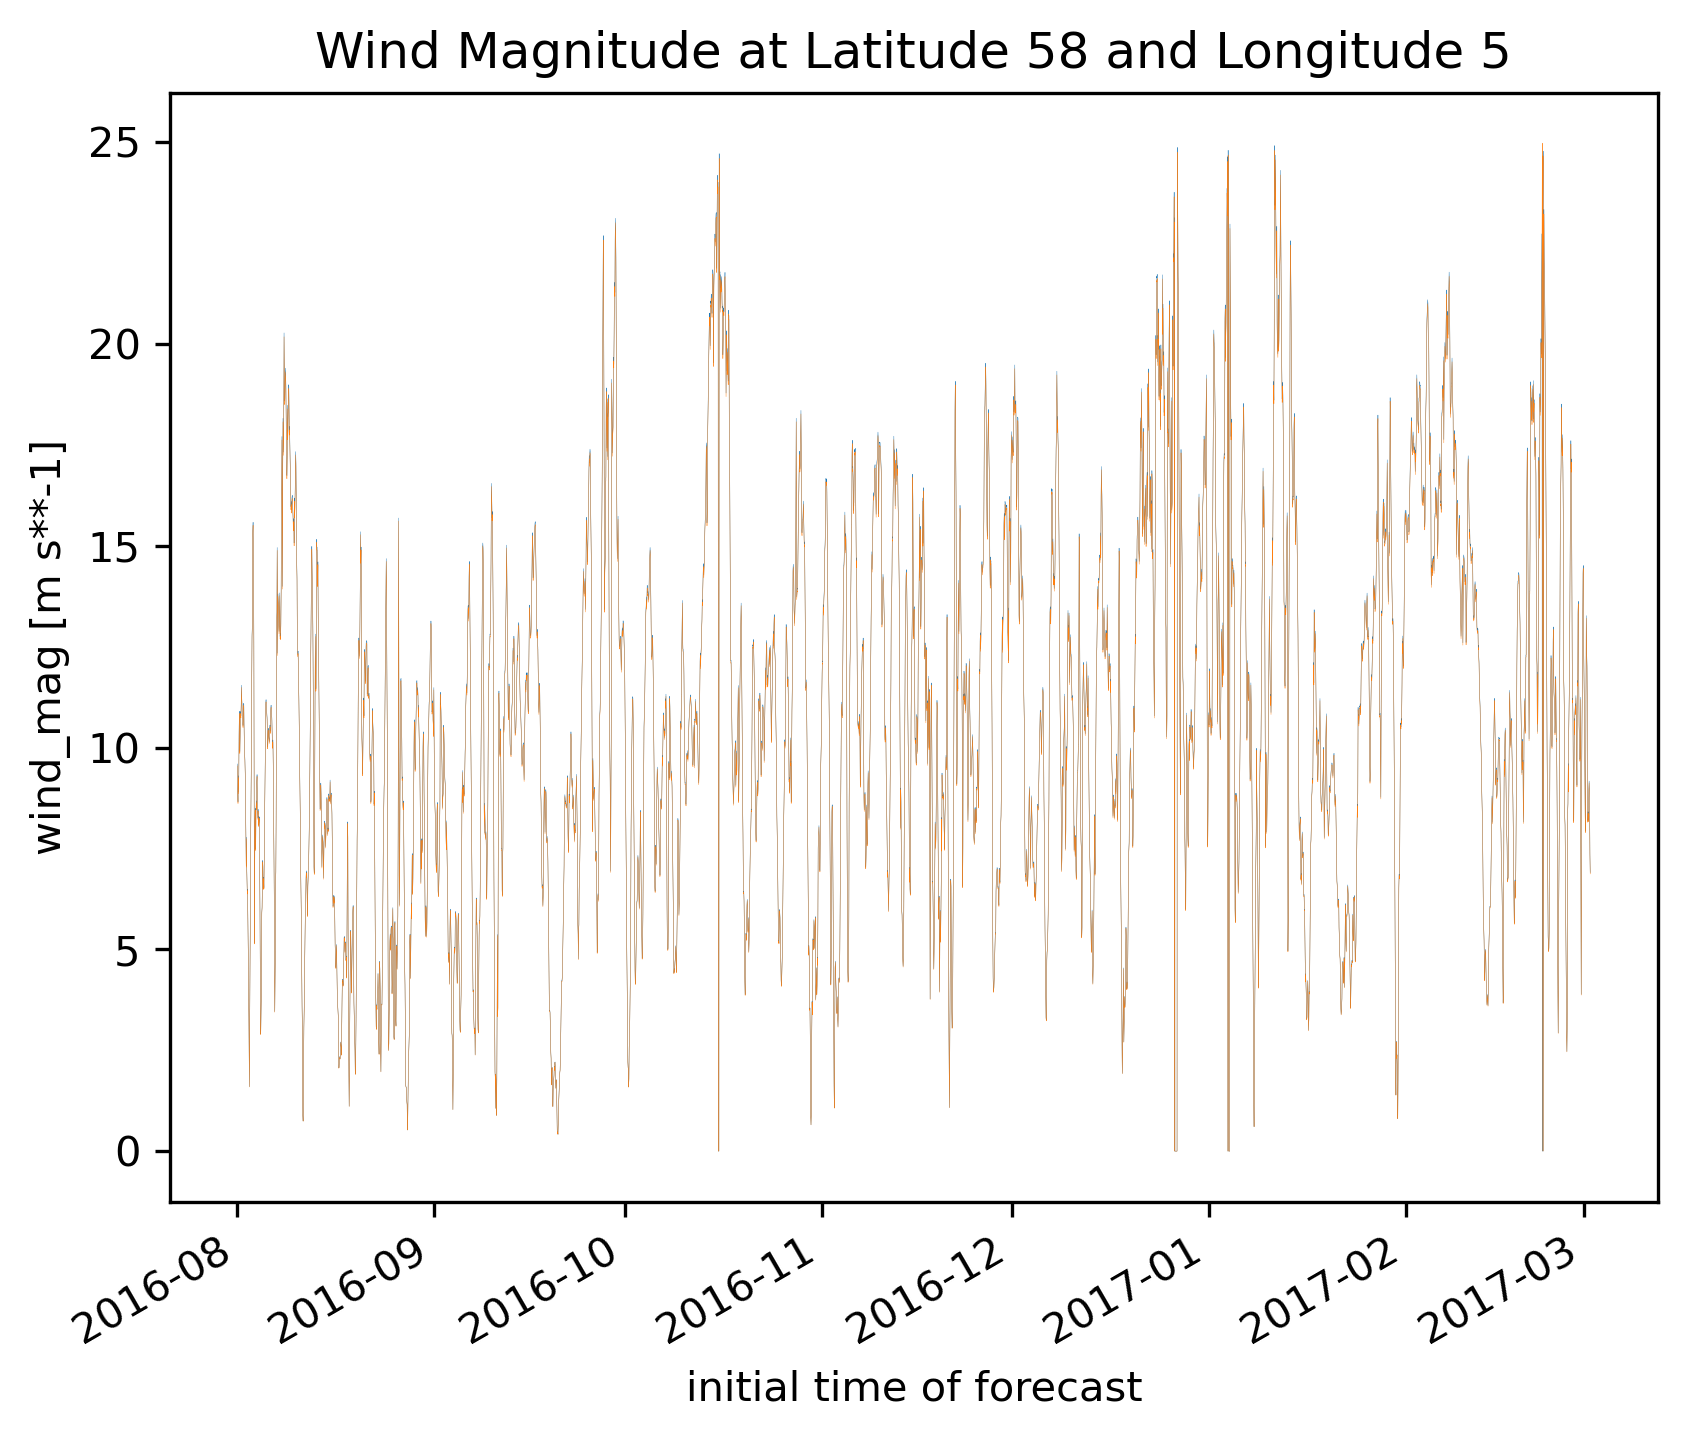

In [14]:
longitude = 5
latitude = 58

#plotting
plt.figure(dpi=300)
ds3.sel(latitude=[latitude], longitude=[longitude],time=slice('2016-08-01', '2017-03-01'))['wind_mag'].plot(linewidth=0.1)
ds4.sel(latitude=[latitude], longitude=[longitude],time=slice('2016-08-01', '2017-03-01'))['wind_mag'].plot(linewidth=0.1)

plt.title('Wind Magnitude at Latitude {} and Longitude {}'.format(latitude, longitude))

Text(0.5, 1.0, 'Wind Magnitude at Latitude 58 and Longitude 5')

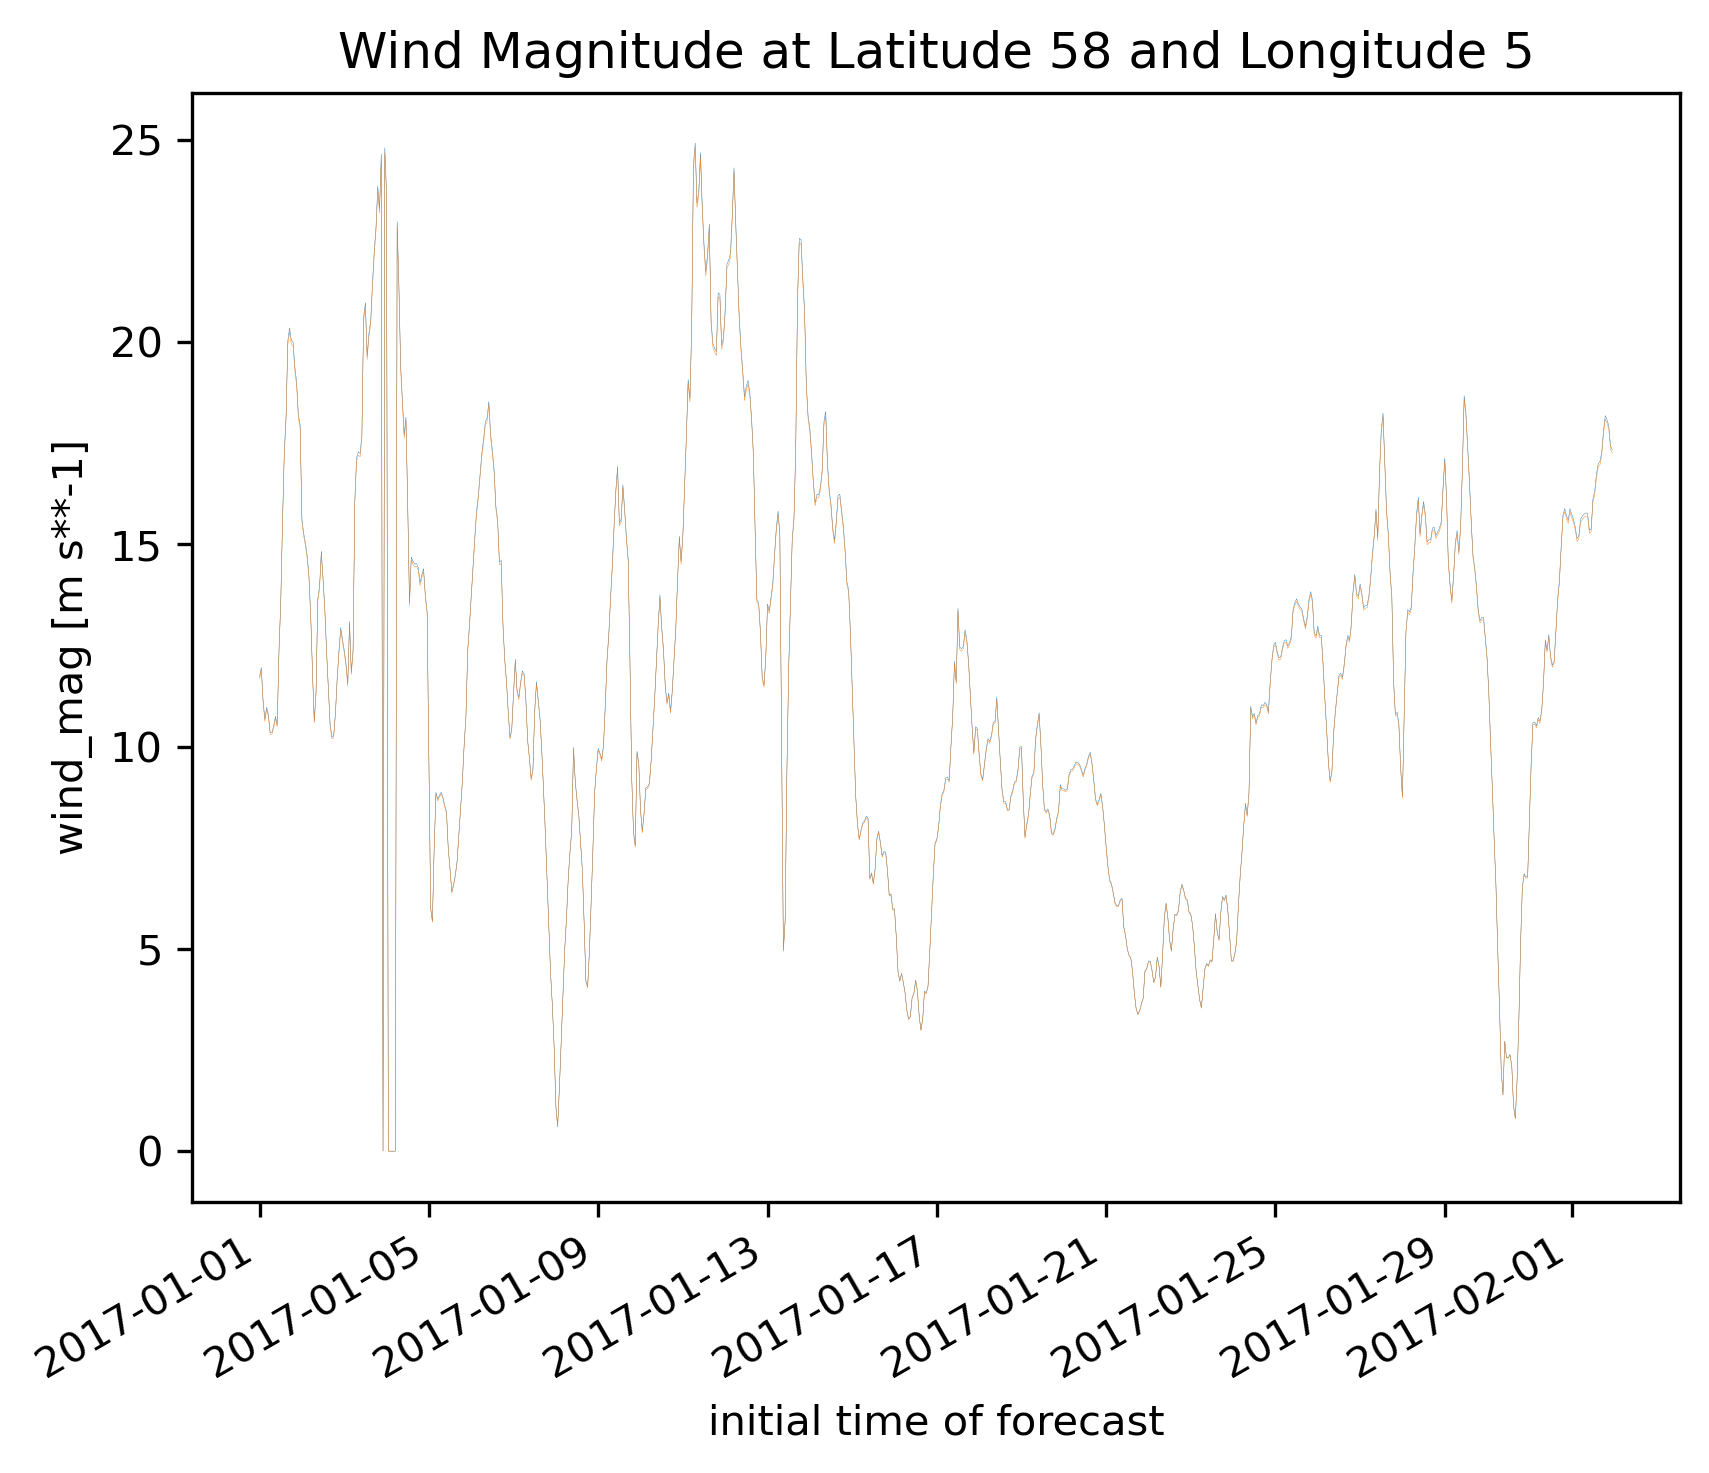

In [15]:
longitude = 5
latitude = 58

#plotting
plt.figure(dpi=300)
ds3.sel(latitude=[latitude], longitude=[longitude],time=slice('2017-01-01', '2017-02-01'))['wind_mag'].plot(linewidth=0.1)
ds4.sel(latitude=[latitude], longitude=[longitude],time=slice('2017-01-01', '2017-02-01'))['wind_mag'].plot(linewidth=0.1)

plt.title('Wind Magnitude at Latitude {} and Longitude {}'.format(latitude, longitude))

The 2 periods of data above show the wind magnitude in the north sea (8E, 58N), during the periods January 15–17 and January 22–25 2017 a Dunkelflaute period occured, the figure above shows a well defined region of when the wind speed magnitude drops significantly for a prolonged period of time as suggested in the text. 

credit: https://onlinelibrary.wiley.com/doi/full/10.1002/we.2554

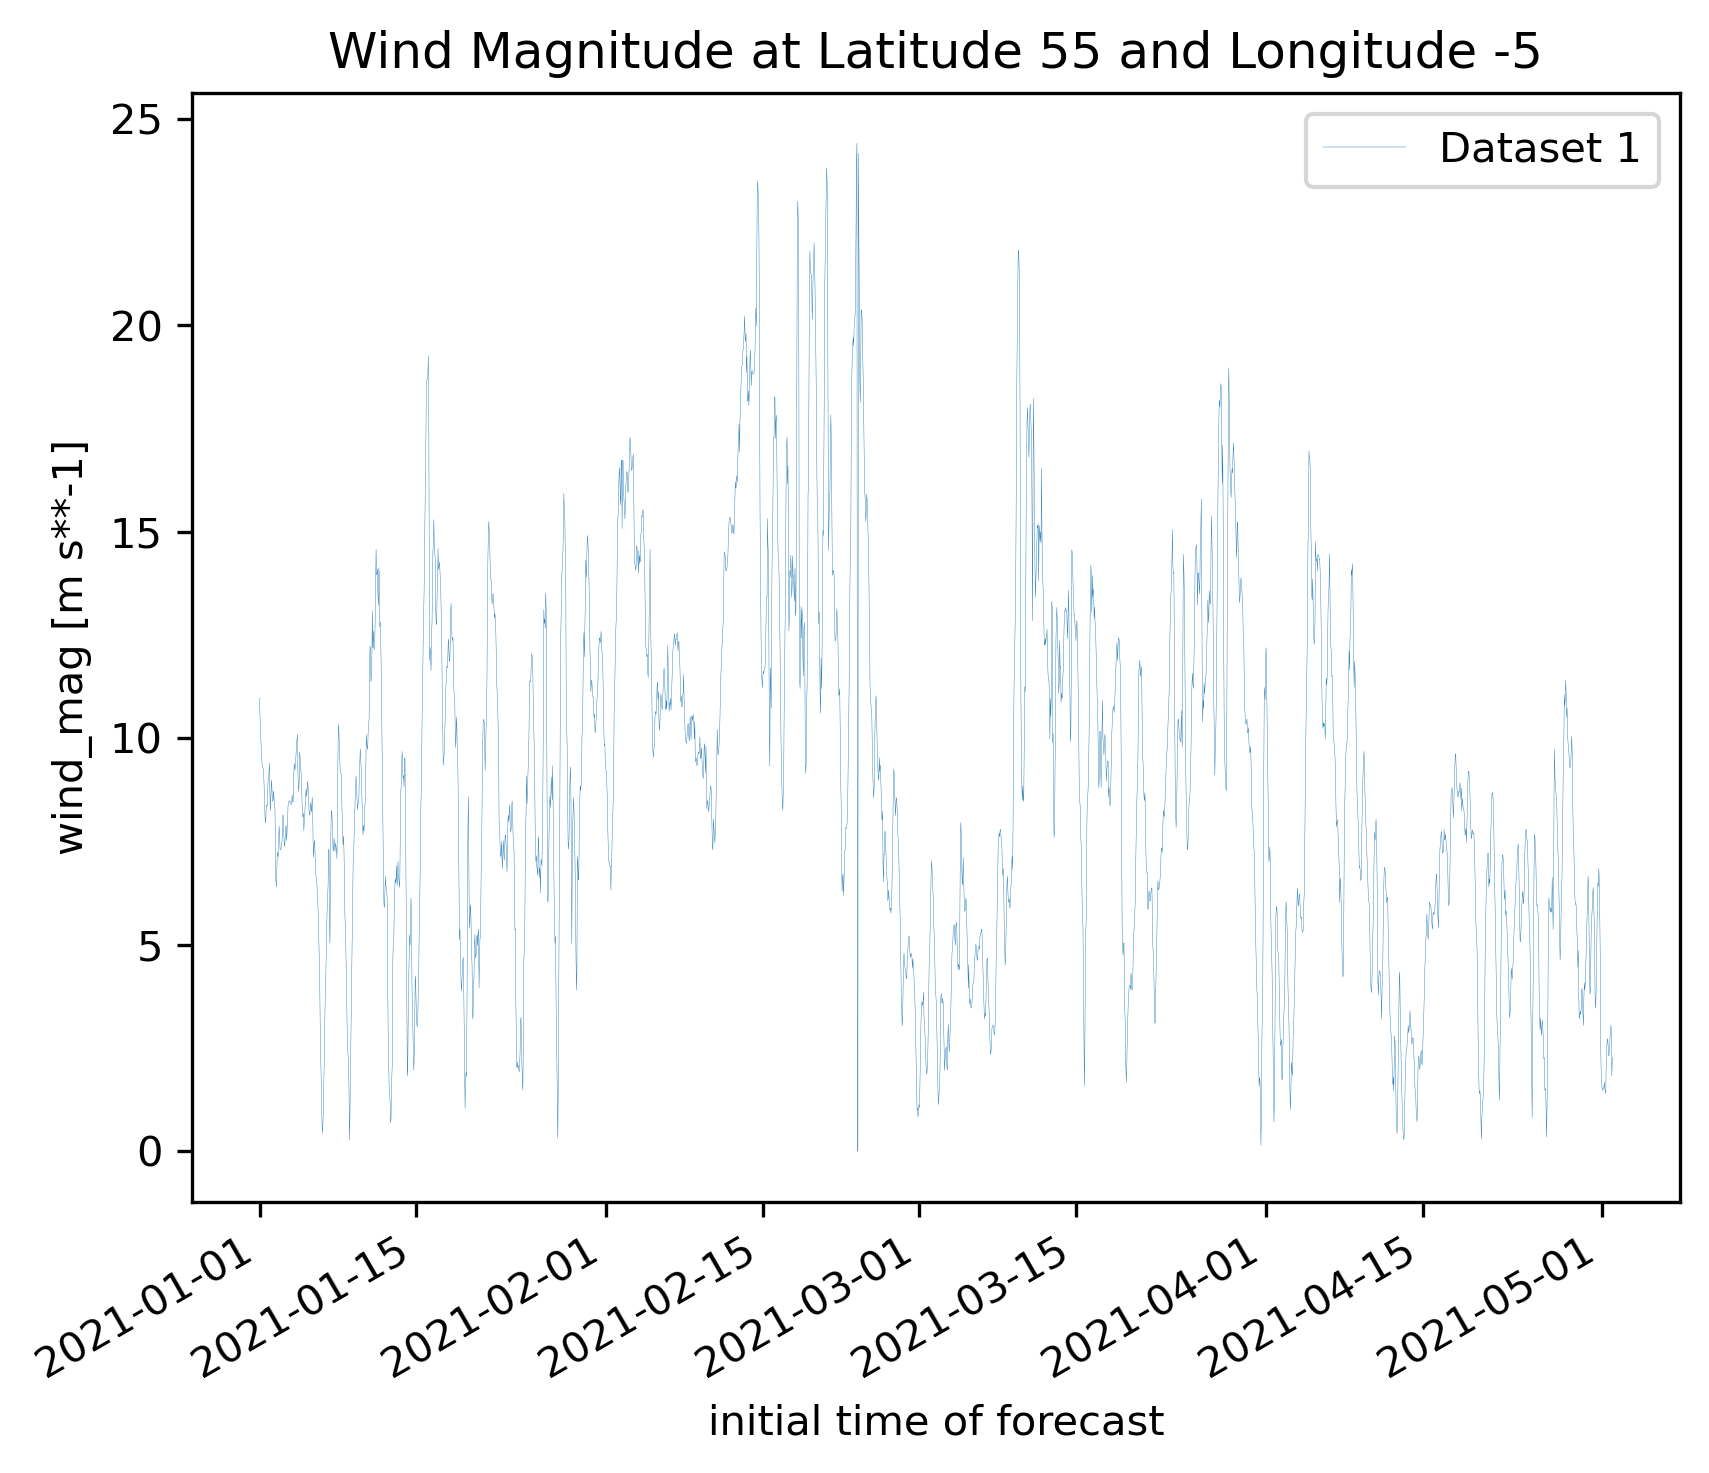

In [16]:


longitude = -5
latitude = 55

# Plotting
plt.figure(dpi=300)

# Assuming 'wind_mag' is the variable name in your dataset
ds.sel(latitude=latitude, longitude=longitude, time=slice('2021-01-01', '2021-05-01'))['wind_mag'].plot(linewidth=0.1, label='Dataset 1')

plt.title('Wind Magnitude at Latitude {} and Longitude {}'.format(latitude, longitude))
plt.legend()
plt.show()

